In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
#from xgboost import XGBoostRegressor
from lightgbm import LGBMRegressor

In [ ]:
!pip install xgboost

In [ ]:
data = pd.read_csv('/content/Nifty50_consolidated.csv')

data=data.iloc[::-1].reset_index(drop=True)
data['Open '].head()


,Open
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [ ]:
data.shape

(8095, 5)

<Axes: >

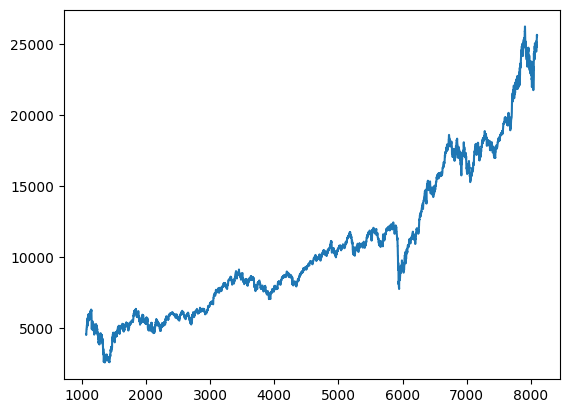

In [ ]:
data['Open '].plot(kind='line')

In [ ]:
data.isnull().sum()

,0
Date,1069
Open,1099
High,1099
Low,1099
Close,1099


In [ ]:
del data['Date ']

data.dropna(inplace=True)

In [ ]:
data.shape

(6996, 4)

In [ ]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0


In [ ]:
data.columns = data.columns.str.strip()

In [ ]:
data_chunks = {}
def stock_chunks_maker(column_name, column, chunk_size):
    x_name = f'X_{column_name}_{chunk_size}'
    y_name = f'Y_{column_name}_{chunk_size}'
    x = []
    y = []
    for i in range(len(column)-chunk_size):
        x.append(column.iloc[i:i+chunk_size].values)
        y.append(column.iloc[i+chunk_size])
    data_chunks[x_name] = x
    data_chunks[y_name] = y

slicing = [30,60,90,120,150]
for col in data.columns:
    for chunk in slicing:
        stock_chunks_maker(col, data[col],chunk)
print(data_chunks.keys())

dict_keys(['X_Open_30', 'Y_Open_30', 'X_Open_60', 'Y_Open_60', 'X_Open_90', 'Y_Open_90', 'X_Open_120', 'Y_Open_120', 'X_Open_150', 'Y_Open_150', 'X_High_30', 'Y_High_30', 'X_High_60', 'Y_High_60', 'X_High_90', 'Y_High_90', 'X_High_120', 'Y_High_120', 'X_High_150', 'Y_High_150', 'X_Low_30', 'Y_Low_30', 'X_Low_60', 'Y_Low_60', 'X_Low_90', 'Y_Low_90', 'X_Low_120', 'Y_Low_120', 'X_Low_150', 'Y_Low_150', 'X_Close_30', 'Y_Close_30', 'X_Close_60', 'Y_Close_60', 'X_Close_90', 'Y_Close_90', 'X_Close_120', 'Y_Close_120', 'X_Close_150', 'Y_Close_150'])


In [ ]:
dataframes_by_column_chunk = {}
columns_to_process = data.columns
chunk_sizes_to_process = slicing

for col in columns_to_process:
    for chunk_size in chunk_sizes_to_process:
        x_key = f'X_{col}_{chunk_size}'
        y_key = f'Y_{col}_{chunk_size}'

        if x_key in data_chunks and y_key in data_chunks:

            x_data = data_chunks[x_key]
            y_data = data_chunks[y_key]

            df = pd.DataFrame(x_data)

            df['Label'] = y_data


            df_name = f'{col}_{chunk_size}_df'
            dataframes_by_column_chunk[df_name] = df


print("\nAll requested DataFrames created:")
print(dataframes_by_column_chunk.keys())

# Display the head of one of the created DataFrames as an example
if dataframes_by_column_chunk:
    example_key = list(dataframes_by_column_chunk.keys())[0]
    print(f"\nHead of DataFrame '{example_key}':")
    display(dataframes_by_column_chunk[example_key].head())


All requested DataFrames created:
dict_keys(['Open_30_df', 'Open_60_df', 'Open_90_df', 'Open_120_df', 'Open_150_df', 'High_30_df', 'High_60_df', 'High_90_df', 'High_120_df', 'High_150_df', 'Low_30_df', 'Low_60_df', 'Low_90_df', 'Low_120_df', 'Low_150_df', 'Close_30_df', 'Close_60_df', 'Close_90_df', 'Close_120_df', 'Close_150_df'])

Head of DataFrame 'Open_30_df':


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,Label
0,4518.450195,4494.100098,4550.250000,4734.850098,4752.950195,4837.149902,4939.100098,4937.600098,4942.700195,4996.450195,...,5658.899902,5551.100098,5360.350098,5202.750000,5185.299805,5477.600098,5499.049805,5564.250000,5708.899902,5917.549805
1,4494.100098,4550.250000,4734.850098,4752.950195,4837.149902,4939.100098,4937.600098,4942.700195,4996.450195,5021.500000,...,5551.100098,5360.350098,5202.750000,5185.299805,5477.600098,5499.049805,5564.250000,5708.899902,5917.549805,5868.899902
2,4550.250000,4734.850098,4752.950195,4837.149902,4939.100098,4937.600098,4942.700195,4996.450195,5021.500000,5069.000000,...,5360.350098,5202.750000,5185.299805,5477.600098,5499.049805,5564.250000,5708.899902,5917.549805,5868.899902,5903.799805
3,4734.850098,4752.950195,4837.149902,4939.100098,4937.600098,4942.700195,4996.450195,5021.500000,5069.000000,5211.649902,...,5202.750000,5185.299805,5477.600098,5499.049805,5564.250000,5708.899902,5917.549805,5868.899902,5903.799805,5854.850098
4,4752.950195,4837.149902,4939.100098,4937.600098,4942.700195,4996.450195,5021.500000,5069.000000,5211.649902,5208.149902,...,5185.299805,5477.600098,5499.049805,5564.250000,5708.899902,5917.549805,5868.899902,5903.799805,5854.850098,5931.899902


### Pass each dataframe with all regression models to check the accuracy


In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(),
    'Neural Network Regressor': MLPRegressor(),
    #'XGBoost Regressor': XGBoostRegressor(), # Uncomment if XGBoost is needed and imported
    'LightGBM Regressor': LGBMRegressor()
}

print("Dictionary of models created:")
print(models.keys())



Dictionary of models created:
dict_keys(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Elastic Net', 'Decision Tree Regressor', 'Random Forest Regressor', 'Gradient Boosting Regressor', 'Support Vector Regressor', 'K-Nearest Neighbors Regressor', 'Neural Network Regressor', 'LightGBM Regressor'])


In [ ]:
results = {}

# Iterate through each DataFrame
for df_name, df in dataframes_by_column_chunk.items():
    print(f"Processing DataFrame: {df_name}")

    # Prepare data (Assuming 'Label' is the target column and others are features)
    X = df.drop('Label', axis=1)
    y = df['Label']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Using a common test size and random state

    # Store results for this DataFrame
    results[df_name] = {}

    # Iterate through each model
    for model_name, model in models.items():
        print(f"  Training and evaluating model: {model_name}")

        try:
            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Evaluate the model
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)

            # Store the results
            results[df_name][model_name] = {
                'Mean Squared Error': mse,
                'Mean Absolute Error': mae
            }

        except Exception as e:
            # Handle potential errors during training or prediction
            results[df_name][model_name] = {
                'Error': str(e)
            }
            print(f"  Error training/evaluating {model_name}: {e}")

# Display the results
print("\n--- Evaluation Results ---")
for df_name, model_results in results.items():
    print(f"\nResults for {df_name}:")
    for model_name, metrics in model_results.items():
        if 'Error' in metrics:
            print(f"  {model_name}: Error - {metrics['Error']}")
        else:
            print(f"  {model_name}:")
            print(f"    Mean Squared Error (MSE): {metrics['Mean Squared Error']:.4f}")
            print(f"    Mean Absolute Error (MAE): {metrics['Mean Absolute Error']:.4f}")

Processing DataFrame: Open_30_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e+07, tolerance: 1.551e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e+07, tolerance: 1.551e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 30
[LightGBM] [Info] Start training from score 10790.124367
Processing DataFrame: Open_60_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+08, tolerance: 1.531e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e+08, tolerance: 1.531e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 5548, number of used features: 60
[LightGBM] [Info] Start training from score 10790.898930
Processing DataFrame: Open_90_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e+08, tolerance: 1.527e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net
  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 5524, number of used features: 90
[LightGBM] [Info] Start training from score 10796.816224
Processing DataFrame: Open_120_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+08, tolerance: 1.519e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net
  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 120
[LightGBM] [Info] Start training from score 10829.613559
Processing DataFrame: Open_150_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+08, tolerance: 1.515e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e+08, tolerance: 1.515e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 5476, number of used features: 150
[LightGBM] [Info] Start training from score 10819.653833
Processing DataFrame: High_30_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.987e+07, tolerance: 1.561e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.987e+07, tolerance: 1.561e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net
  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 30
[LightGBM] [Info] Start training from score 10844.893429
Processing DataFrame: High_60_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.627e+07, tolerance: 1.540e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net
  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 5548, number of used features: 60
[LightGBM] [Info] Start training from score 10845.687022
Processing DataFrame: High_90_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Tra

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+08, tolerance: 1.537e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+08, tolerance: 1.537e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 5524, number of used features: 90
[LightGBM] [Info] Start training from score 10851.838457
Processing DataFrame: High_120_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+08, tolerance: 1.529e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e+08, tolerance: 1.529e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 120
[LightGBM] [Info] Start training from score 10884.380991
Processing DataFrame: High_150_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression
  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e+08, tolerance: 1.525e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 5476, number of used features: 150
[LightGBM] [Info] Start training from score 10874.018563
Processing DataFrame: Low_30_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.330e+07, tolerance: 1.537e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.329e+07, tolerance: 1.537e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net
  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 30
[LightGBM] [Info] Start training from score 10717.674130
Processing DataFrame: Low_60_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.834e+07, tolerance: 1.516e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.834e+07, tolerance: 1.516e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 5548, number of used features: 60
[LightGBM] [Info] Start training from score 10718.119586
Processing DataFrame: Low_90_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+08, tolerance: 1.512e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.254e+08, tolerance: 1.512e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 5524, number of used features: 90
[LightGBM] [Info] Start training from score 10724.147371
Processing DataFrame: Low_120_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+08, tolerance: 1.505e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e+08, tolerance: 1.505e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 120
[LightGBM] [Info] Start training from score 10757.520367
Processing DataFrame: Low_150_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+08, tolerance: 1.501e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e+08, tolerance: 1.501e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 5476, number of used features: 150
[LightGBM] [Info] Start training from score 10747.598442
Processing DataFrame: Close_30_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.379e+07, tolerance: 1.550e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.379e+07, tolerance: 1.550e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 5572, number of used features: 30
[LightGBM] [Info] Start training from score 10782.189400
Processing DataFrame: Close_60_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.839e+07, tolerance: 1.529e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.839e+07, tolerance: 1.529e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15300
[LightGBM] [Info] Number of data points in the train set: 5548, number of used features: 60
[LightGBM] [Info] Start training from score 10783.077590
Processing DataFrame: Close_90_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+08, tolerance: 1.525e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+08, tolerance: 1.525e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22950
[LightGBM] [Info] Number of data points in the train set: 5524, number of used features: 90
[LightGBM] [Info] Start training from score 10789.550492
Processing DataFrame: Close_120_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+08, tolerance: 1.518e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+08, tolerance: 1.518e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30600
[LightGBM] [Info] Number of data points in the train set: 5500, number of used features: 120
[LightGBM] [Info] Start training from score 10822.277078
Processing DataFrame: Close_150_df
  Training and evaluating model: Linear Regression
  Training and evaluating model: Ridge Regression
  Training and evaluating model: Lasso Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+08, tolerance: 1.514e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Elastic Net


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e+08, tolerance: 1.514e+07
  model = cd_fast.enet_coordinate_descent(


  Training and evaluating model: Decision Tree Regressor
  Training and evaluating model: Random Forest Regressor
  Training and evaluating model: Gradient Boosting Regressor
  Training and evaluating model: Support Vector Regressor
  Training and evaluating model: K-Nearest Neighbors Regressor
  Training and evaluating model: Neural Network Regressor
  Training and evaluating model: LightGBM Regressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 5476, number of used features: 150
[LightGBM] [Info] Start training from score 10811.763837

--- Evaluation Results ---

Results for Open_30_df:
  Linear Regression:
    Mean Squared Error (MSE): 10987.2747
    Mean Absolute Error (MAE): 54.9694
  Ridge Regression:
    Mean Squared Error (MSE): 10987.2746
    Mean Absolute Error (MAE): 5

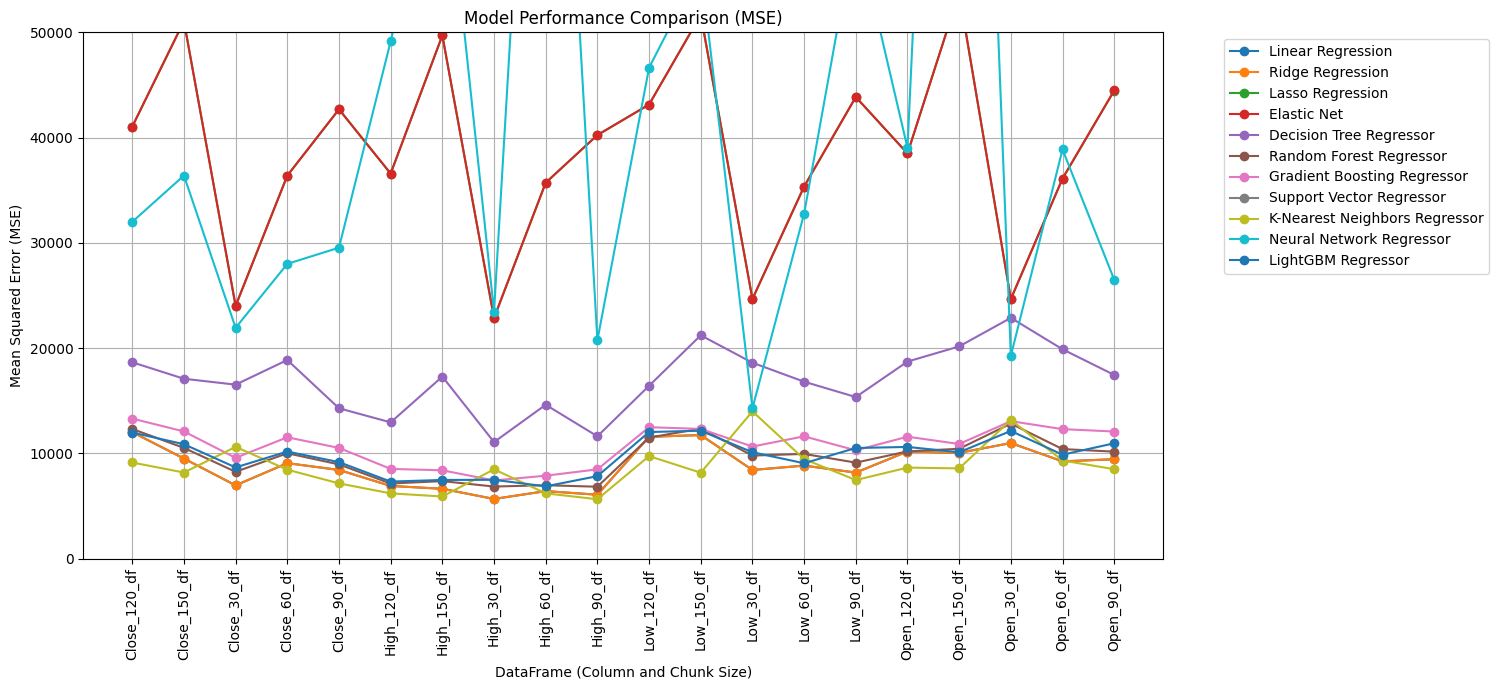

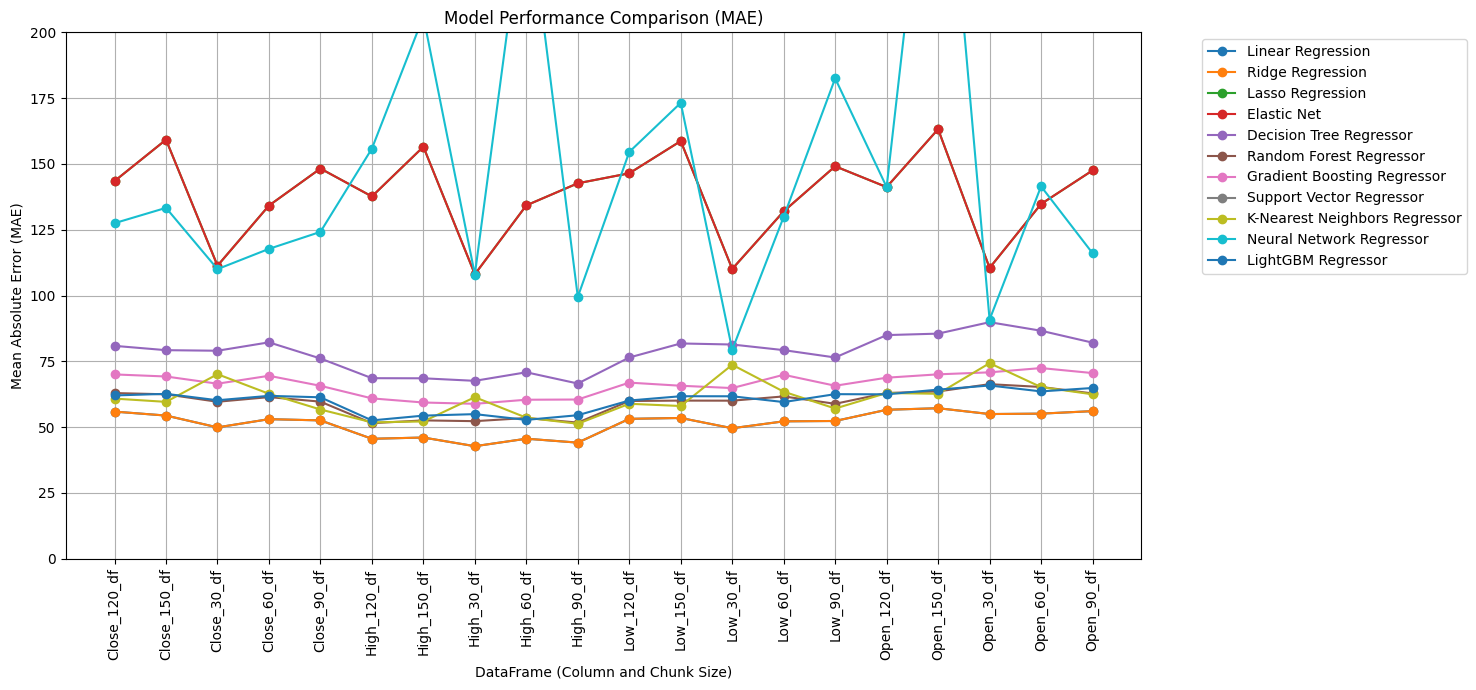

In [21]:
import matplotlib.pyplot as plt

# Prepare data for plotting
mse_data = {}
mae_data = {}

for df_name, model_results in results.items():
    for model_name, metrics in model_results.items():
        if 'Error' not in metrics:
            if model_name not in mse_data:
                mse_data[model_name] = {}
                mae_data[model_name] = {}
            mse_data[model_name][df_name] = metrics['Mean Squared Error']
            mae_data[model_name][df_name] = metrics['Mean Absolute Error']

# Sort the dataframe names for better plotting order
sorted_df_names = sorted(dataframes_by_column_chunk.keys())

# Create MSE plot
plt.figure(figsize=(15, 7))
for model_name, df_metrics in mse_data.items():
    # Ensure the data points are in the correct order corresponding to sorted_df_names
    mse_values = [df_metrics.get(df_name) for df_name in sorted_df_names]
    plt.plot(sorted_df_names, mse_values, marker='o', linestyle='-', label=model_name)

plt.xlabel('DataFrame (Column and Chunk Size)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Model Performance Comparison (MSE)')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 50000) # Adjust the y-axis limit to exclude SVR outliers
plt.show()

# Create MAE plot
plt.figure(figsize=(15, 7))
for model_name, df_metrics in mae_data.items():
    # Ensure the data points are in the correct order corresponding to sorted_df_names
    mae_values = [df_metrics.get(df_name) for df_name in sorted_df_names]
    plt.plot(sorted_df_names, mae_values, marker='o', linestyle='-', label=model_name)

plt.xlabel('DataFrame (Column and Chunk Size)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance Comparison (MAE)')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 200) # Adjust the y-axis limit to exclude SVR outliers
plt.show()